# **Clasificador de Imágenes con Pytorch: Piezas de ajedrez**

*Autores:* Luna Yue Hernández Guerra y Kimberly Casimiro Torres

## **Introducción**
El objetivo es desarrollar un clasificador de imágenes de piezas de ajedrez utilizando una red convolucional con PyTorch. Este modelo se entrenará para reconocer diferentes tipos de piezas, como el alfil, rey, caballo, entre otros.

## **Conjuntos de Datos**
Para llevar a cabo el clasificador, debemos buscar un conjunto de datos con el cual probarlo. En este caso, hemos escogido un dataset de imágenes de piezas de ajedrez. Dicho dataset se puede obtener en [Kaggle](https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset). Su contenido consta de 6 subdirectorios que representan las distintas clases: alfil, rey, caballo, peón, dama y torre. Cada clase contiene entre 75 y 106 imágenes distintas entre sí, con diferentes colores, formas y posiciones.

Para reproducir este experimento, es necesario guardar dicho dataset en la ruta data/raw. Asimismo, se debe crear otro directorio data/processed para guardar con conjuntos de datos modificados durante el desarrollo del estudio, resultando la siguiente estructura de directorios:


``` bash
data/
└── chess/
    └── raw/
        └── Chess/
            ├── Bishop/
            ├── King/
            ├── Knight/
            ├── Pawn/
            ├── Queen/
            └── Rook/
    └── processed/
```

## **Métodos e Implementaciones**
### **Importación de Módulos y Librerías Necesarias**

In [17]:
import os
import cv2
import torch
import optuna
import matplotlib
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split

### **Optimización de Hiperparámetros con Optuna**

Este código implementa un proceso de optimización de hiperparámetros utilizando **Optuna**, un marco para optimizar parámetros de modelos de machine learning. El objetivo principal es encontrar los mejores valores de hiperparámetros para el modelo de red neuronal convolutiva (CNN) diseñado para clasificar imágenes de piezas de ajedrez.

En primer lugar, vamos a utilizar la librería optuna para realizar una búsqueda automatizada de los mejores hiperparámetros. La red cuenta con 3 capas convolutivas, 1 capa de pooling, 2 capas fully-connected y dropout. Los hiperparámetros a estudiar son:
- Tamaño del batch (batch_size): Valores explorados: 16, 32, 64 y 128.
- Tasa de aprendizaje o learning rate (lr): Explorada en un rango logarítmico entre $10^{-5}$ y $10^{-1}$
- Tasa de dropout (dropout_rate): Explorada entre 0.1 y 0.5.

Además, a los datos originales divididos en entrenamiento (80%) y prueba/validación (20%), les aplicamos transformaciones de reescalado, conversión a tensores y normalización de los canales RGB. Aparte, a los datos de entrenamiento se les aplican técnicas de aumento de datos (data augmentation) como inversiones horizontales, rotaciones y ajustes de brillo, contraste y saturación.

In [3]:
def objective(trial):
    # Selección de hiperparámetros
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Ruta de datos
    data_path = 'data/chess/raw'

    # Transformaciones para los datos
    transform_train = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Carga de datos y partición en conjuntos de entrenamiento y prueba
    full_data = datasets.ImageFolder(root=data_path, transform=transform_train)
    train_size = int(0.8 * len(full_data))
    test_size = len(full_data) - train_size
    train_data, test_data = random_split(full_data, [train_size, test_size])
    test_data.dataset.transform = transform_test

    # Creación de dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Definición del modelo CNN
    class ConvNet(nn.Module):
        def __init__(self, num_classes, dropout_rate):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(128 * 8 * 8, 256)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # Configuración del dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Inicialización del modelo, función de pérdida y optimizador
    num_classes = len(full_data.classes)
    model = ConvNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Entrenamiento
    epochs = 5
    for _ in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

# Optimización de hiperparámetros
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-27 09:36:06,239] A new study created in memory with name: no-name-647c883c-34a8-498c-8df1-658a98301564
[I 2024-12-27 09:36:43,420] Trial 0 finished with value: 37.83783783783784 and parameters: {'batch_size': 16, 'lr': 0.0014636440702344704, 'dropout_rate': 0.26735668542155555}. Best is trial 0 with value: 37.83783783783784.
[I 2024-12-27 09:37:15,924] Trial 1 finished with value: 19.81981981981982 and parameters: {'batch_size': 16, 'lr': 0.0037319390467181754, 'dropout_rate': 0.4851105670667797}. Best is trial 0 with value: 37.83783783783784.
[I 2024-12-27 09:37:41,228] Trial 2 finished with value: 14.414414414414415 and parameters: {'batch_size': 128, 'lr': 0.028284740357325897, 'dropout_rate': 0.3139781816420178}. Best is trial 0 with value: 37.83783783783784.
[I 2024-12-27 09:38:10,810] Trial 3 finished with value: 22.52252252252252 and parameters: {'batch_size': 32, 'lr': 0.00024367764085724493, 'dropout_rate': 0.14402853850775701}. Best is trial 0 with value: 37.837837

Best hyperparameters: {'batch_size': 16, 'lr': 0.0014636440702344704, 'dropout_rate': 0.26735668542155555}


El proceso de optimización con **Optuna** identificó los mejores hiperparámetros para el modelo de red neuronal convolutiva (CNN), obteniendo un tamaño de lote (`batch_size`) de 16, una tasa de aprendizaje (`lr`) de aproximadamente 0.0014, y una tasa de dropout (`dropout_rate`) del 26.7%.  Estos valores representan una configuración óptima para maximizar la precisión y proporcionar un modelo robusto y eficiente.

In [ ]:
batch_size = study.best_params['batch_size']
lr = study.best_params['lr']
dropout_rate = study.best_params['dropout_rate']

### **Clasificadores**

#### **1. Transformaciones y Carga de Datos**

En esta sección, se cargan y transforman las imágenes para prepararlas como entrada para el modelo de clasificación. Las imágenes se redimensionan a 64x64 píxeles para asegurar uniformidad, se convierten a tensores y se normalizan al rango [-1, 1] para facilitar el entrenamiento del modelo. Posteriormente, el conjunto de datos completo se divide en dos partes: un 80% para el entrenamiento del modelo y un 20% para la evaluación en el conjunto de prueba, asegurando que ambas divisiones mantengan la misma estructura y transformaciones.

In [8]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/chess/raw'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#### **2. Definición de Modelos CNN**
Se definen tres modelos con arquitecturas de diferente complejidad. Cada modelo utiliza varias capas convolutivas y de pooling para extraer características de las imágenes, seguido de capas totalmente conectadas para la clasificación final.
##### **Modelo Básico: ConvNet**
Esta red se compone de tres capas convolutivas, una capa de pooling y dos capas fully-connected. Asimismo, en el método fordward se utiliza la función ReLu como función de activación. 

Por otro lado, la red utiliza diferentes valores para los hiperparámetros kernel_size, stride y padding. Recordemos que el kernel_size hace referencia al tamaño del núcleo, el stride hace referencia a los 'pasos' o 'saltos' dados por el kernel y el padding hace referencia al número de píxeles agregados en los bordes.

In [9]:
class ConvNet(nn.Module):
    def __init__(self, classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### **Modelo Avanzado: ConvNet2**
Esta red añade una capa convolutiva más que la red básica `ConvNet` ya definida.

In [11]:
class ConvNet2(nn.Module):
    def __init__(self, classes):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.shape)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### **Modelo Complejo: ConvNet3**
Esta red posee seis capas convolutivas, una de pooling, dos fully-connected y una capa de dropout. Esta última capa sirve para prevenir el sobreajuste ya que desactiva aleatoriamente neuronas durante el entrenamiento. 

In [34]:
class ConvNet3(nn.Module):
    def __init__(self, classes):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        # print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### **3. Parada Temprana**
Se implementa un mecanismo de parada temprana para detener el entrenamiento si no se mejora la pérdida de validación después de un número de épocas consecutivas `tolerance`, evitando sobreajuste y ahorro de tiempo. Dicha mejora se compara con el valor de `min_delta`.

In [21]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_val_loss = float('inf')

    def __call__(self, validation_loss):
        if (self.best_val_loss - validation_loss) > self.min_delta:
            self.counter = 0  
            self.best_val_loss = validation_loss
        else:
            self.counter += 1 
        
        if self.counter >= self.tolerance:
            self.early_stop = True
            print("Parada temprana activada. No hay mejora en la pérdida de validación.")

#### **4. Entrenamiento y Evaluación**

##### **Función para Entrenar el Modelo por Época**
Esta función realiza una época de entrenamiento sobre el conjunto de datos de entrada. Durante esta etapa, procesa los datos en pequeños lotes, calculando primero las predicciones del modelo para cada lote. Luego, evalúa el error de las predicciones comparándolas con las etiquetas reales utilizando una función de pérdida. A continuación, ajusta los pesos del modelo mediante el proceso de retropropagación, que calcula los gradientes, y el optimizador, que actualiza los pesos para minimizar la pérdida. Al finalizar la época, la función calcula y devuelve la pérdida promedio acumulada y la precisión del modelo, lo que proporciona una evaluación del rendimiento del modelo durante esa fase de entrenamiento.

In [13]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_train_loss, accuracy

##### **Función para Evaluar el Modelo**
Esta función evalúa el rendimiento del modelo utilizando el conjunto de prueba. Para cada lote de datos en este conjunto, calcula las predicciones del modelo y evalúa el error comparándolas con las etiquetas reales mediante una función de pérdida. Además, registra las etiquetas reales y las predicciones generadas, lo que permite realizar análisis posteriores, como la creación de una matriz de confusión. Al finalizar, la función devuelve la pérdida promedio acumulada en el conjunto de prueba, la precisión del modelo y una lista con todas las etiquetas reales y las predicciones, proporcionando así una visión completa del desempeño del modelo en datos no vistos.

In [14]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy, all_labels, all_preds

##### **Función para Graficar Métricas**
Esta función muestra la gráfica de pérdidas y la gráfica de precisiones durante el entrenamiento para los conjuntos de entrenamiento y validación, y una matriz de confusión de este último conjunto.

In [15]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

def plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, classes):
 
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses[:epochs_trained], label="Training Loss")
    plt.plot(range(1, epochs_trained + 1), test_losses[:epochs_trained], label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies[:epochs_trained], label="Training Accuracy")
    plt.plot(range(1, epochs_trained + 1), test_accuracies[:epochs_trained], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Test Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Matriz de confusión
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for true_label, pred_label in zip(all_labels, all_preds):
        confusion_matrix[true_label, pred_label] += 1

    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(confusion_matrix, cmap='Blues')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

##### **Función para Entrenar el Modelo**
La siguiente función se encarga de entrenar al modelo. Para ello, tiene como hiperparámetro el modelo, los conjuntos de entrenamiento y test, la función de pérdida, el optimizador, la función de parada temprana si existe, el número de épocas a entrenar y la época en la que se empieza a evaluar la parada temprana si existe. Esto último sirve para modelos más complejos que tardan en encontrar mejoría durante las primeras épocas.

La dinámica es la siguiente: Se entrena el modelo con el conjunto de entrenamiento y la función `train_one_epoch()`, y mientras se usan los datos de validación para evaluar dicho modelo con la función `evaluate()`. Asimismo, se comprueba si se cumplen las condiciones de parada temprana y una vez finalizado el entrenamiento, se grafican los resultados.

In [16]:

def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs, start_early_stop=1):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs_trained = 0

    for epoch in range(epochs):
        # Entrenamiento por una época
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

        # Evaluación en el conjunto de prueba
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.early_stop and epoch>start_early_stop:
                print(f"Entrenamiento detenido en la época {epoch + 1} debido a la parada temprana.")
                epochs_trained = epoch + 1
                break
    else:
        epochs_trained = epochs

    # Graficar resultados
    plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, model.classes)
    return model

## **Experimentos**
### **Clasificador Básico - Sin Parada Temprana**
El siguiente clasificador se define con el modelo básico `ConvNet` que recordemos que tiene tres capas convolutivas. Luego, como función de pérdida escogeremos la entropía cruzada y como optimizador, el Adam. Por otro lado, no aplicamos la parada temprana y evaluaremos 50 épocas. ¿Qué ocurre si no implementamos la parada temprana?

Epoch 1, Training Loss: 1.8403782844543457, Training Accuracy: 17.687074829931973%
Epoch 1, Test Loss: 1.7890631130763464, Test Accuracy: 18.91891891891892%
Epoch 2, Training Loss: 1.7888817489147186, Training Accuracy: 20.408163265306122%
Epoch 2, Test Loss: 1.7888774701527186, Test Accuracy: 18.01801801801802%
Epoch 3, Training Loss: 1.7794744372367859, Training Accuracy: 24.03628117913832%
Epoch 3, Test Loss: 1.770228454044887, Test Accuracy: 21.62162162162162%
Epoch 4, Training Loss: 1.719833961554936, Training Accuracy: 29.25170068027211%
Epoch 4, Test Loss: 1.7046105691364832, Test Accuracy: 24.324324324324323%
Epoch 5, Training Loss: 1.5786511855466026, Training Accuracy: 39.002267573696145%
Epoch 5, Test Loss: 1.7333845411028181, Test Accuracy: 27.92792792792793%
Epoch 6, Training Loss: 1.378606413091932, Training Accuracy: 46.03174603174603%
Epoch 6, Test Loss: 1.631682140486581, Test Accuracy: 31.53153153153153%
Epoch 7, Training Loss: 1.1049313587801797, Training Accuracy: 5

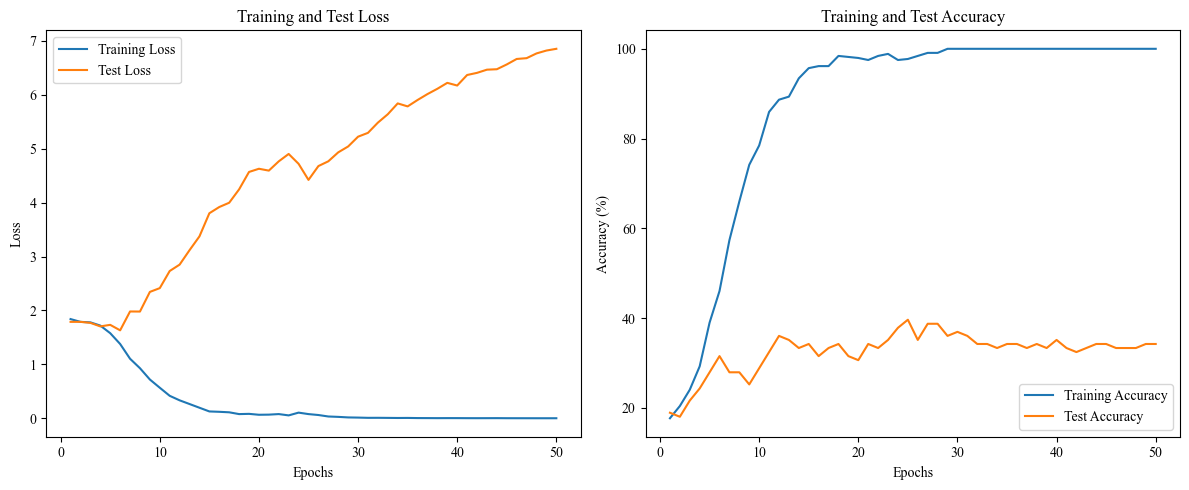

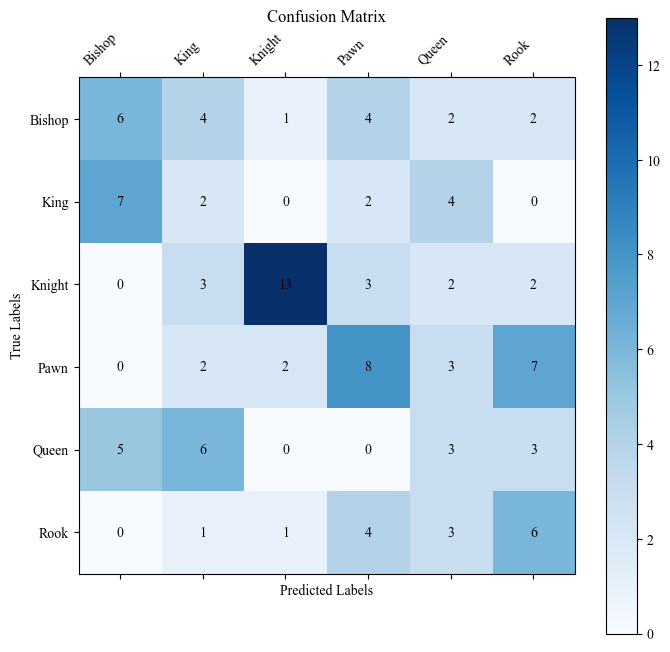

In [19]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, [], epochs=50)

Como podemos observar en las gráficas obtenidas, el modelo comienza a sobreajustar antes de la época 10. Esto significa que el modelo aprende bastante bien los datos de entrenamiento pero no generaliza, dando como resultado que los datos nuevos o desconocidos no los clasifique bien. Asimismo, vemos que el modelo ha gastado un tiempo valioso en seguir entrenando con sobreajuste. Por ello, es necesario aplicar una función de parada temprana para evitar dicho sobreajuste y parar el entrenamiento cuando no se encuentren mejoras.

### **Clasificador Básico - Con Parada Temprana**
En este clasificador, vamos a añadir la implementación de la parada temprana para ver las diferencias. Definimos la tolerancia a 5 épocas y la mejora debe ser mayor a 0.01. Los demás parámetros los dejamos igual. Veremos qué ocurre:

Epoch 1, Training Loss: 1.9087819116456168, Training Accuracy: 13.378684807256235%
Epoch 1, Test Loss: 1.79522819178445, Test Accuracy: 13.513513513513514%
Epoch 2, Training Loss: 1.7884592371327537, Training Accuracy: 16.3265306122449%
Epoch 2, Test Loss: 1.785430669784546, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.7337080878870827, Training Accuracy: 25.85034013605442%
Epoch 3, Test Loss: 1.7324809346880232, Test Accuracy: 22.52252252252252%
Epoch 4, Training Loss: 1.5958903687340873, Training Accuracy: 35.374149659863946%
Epoch 4, Test Loss: 1.7067530495779855, Test Accuracy: 26.126126126126128%
Epoch 5, Training Loss: 1.4321555367537908, Training Accuracy: 42.40362811791383%
Epoch 5, Test Loss: 1.644699215888977, Test Accuracy: 30.63063063063063%
Epoch 6, Training Loss: 1.2228411457368307, Training Accuracy: 52.38095238095238%
Epoch 6, Test Loss: 1.6722299541745866, Test Accuracy: 32.432432432432435%
Epoch 7, Training Loss: 1.009660644190652, Training Accuracy: 60

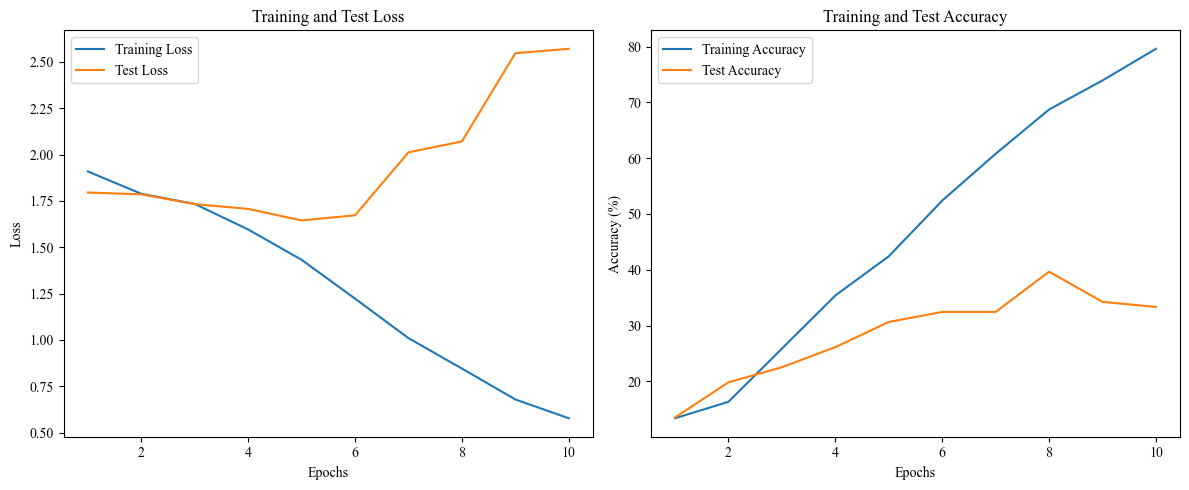

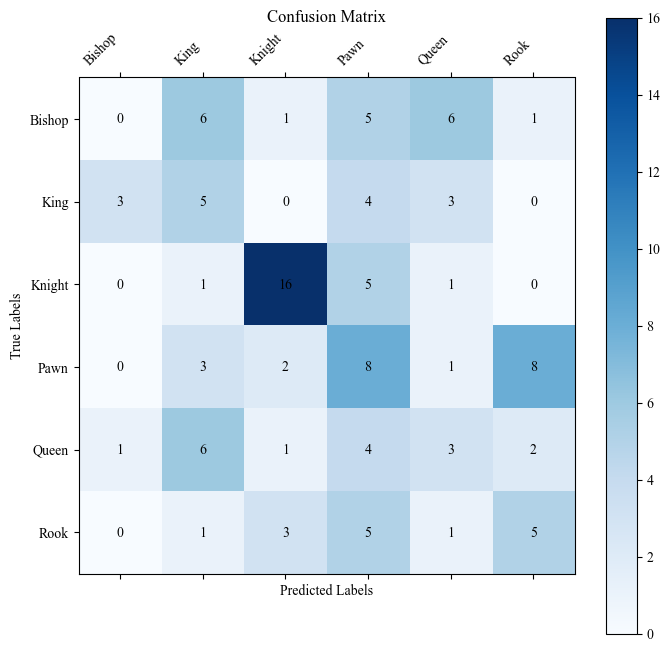

In [22]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

Como estaba previsto, el modelo comienza a sobreajustar y por tanto, los resultados obtenidos en épocas posteriores no mejorarán. Por ello, se realiza una parada temprana. En este caso, el entrenamiento se paró en la época 10, puesto que no ha habido ninguna mejora desde la época 5. 

Entonces, observando los resultados podemos llegar a la conclusión que este clasificador no obtiene un buen resultado, pues tiene una precisión en el conjunto de entrenamiento del 33.33%. 

Así que debemos probar con otras configuraciones.

### **Clasificador Básico - Con 4 capas convolutivas**
Para el siguiente caso, utilizaremos el clasificador `ConvNet2` con una capa convolutiva más.

Epoch 1, Training Loss: 1.7988593450614385, Training Accuracy: 18.594104308390023%
Epoch 1, Test Loss: 1.7891042913709367, Test Accuracy: 13.513513513513514%
Epoch 2, Training Loss: 1.7816298604011536, Training Accuracy: 17.46031746031746%
Epoch 2, Test Loss: 1.7868617602757044, Test Accuracy: 13.513513513513514%
Epoch 3, Training Loss: 1.7797467495713915, Training Accuracy: 18.820861678004537%
Epoch 3, Test Loss: 1.7800507886069161, Test Accuracy: 20.72072072072072%
Epoch 4, Training Loss: 1.7770407327583857, Training Accuracy: 17.913832199546484%
Epoch 4, Test Loss: 1.7704370873314994, Test Accuracy: 10.81081081081081%
Epoch 5, Training Loss: 1.743937258209501, Training Accuracy: 23.582766439909296%
Epoch 5, Test Loss: 1.7610182080950056, Test Accuracy: 17.117117117117118%
Epoch 6, Training Loss: 1.663768687418529, Training Accuracy: 27.664399092970523%
Epoch 6, Test Loss: 1.7307718651635307, Test Accuracy: 24.324324324324323%
Epoch 7, Training Loss: 1.5743404967444283, Training Accu

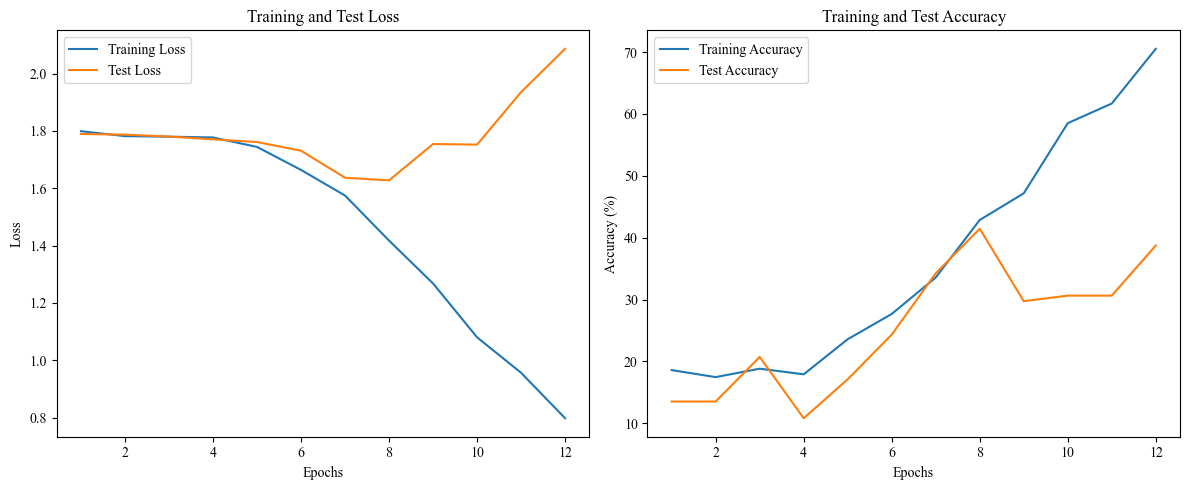

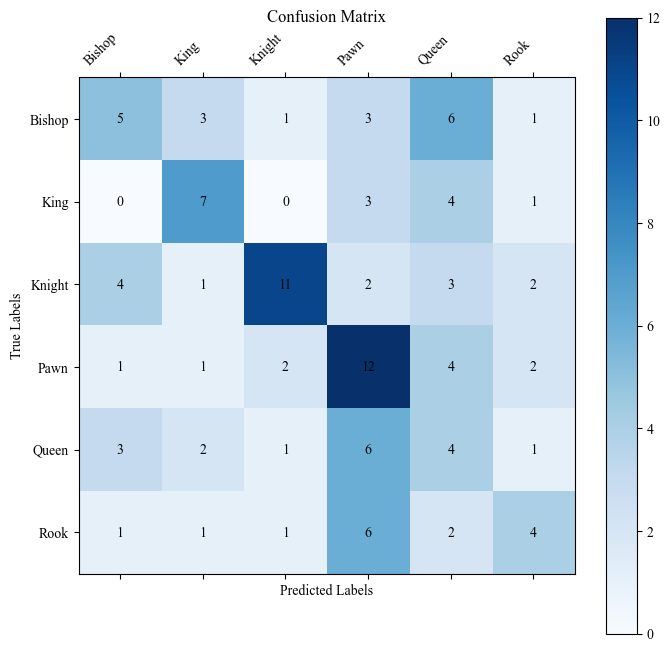

In [23]:
# Configuración inicial
model = ConvNet2(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

Observamos que la mejora no es muy significativa, puesto que todavía hay muchas clases que confunde. 

Probemos con uno más potente.

### **Clasificador Básico - Con 6 capas convolutivas y Dropout**
Utilizamos ahora el clasificador `ConvNet3` que posee 6 capas convolutivas y una de dropout. Además, indicamos que active la parada temprana a partir de la época 10, ya que al tener más capas convolutivas, tarda más en mejorar durante el entrenamiento.

Epoch 1, Training Loss: 1.8021348118782043, Training Accuracy: 17.687074829931973%
Epoch 1, Test Loss: 1.7918545348303658, Test Accuracy: 13.513513513513514%
Epoch 2, Training Loss: 1.78243122782026, Training Accuracy: 18.140589569160998%
Epoch 2, Test Loss: 1.7886005129132951, Test Accuracy: 13.513513513513514%
Epoch 3, Training Loss: 1.7813703290053777, Training Accuracy: 19.501133786848072%
Epoch 3, Test Loss: 1.7910045896257674, Test Accuracy: 13.513513513513514%
Epoch 4, Training Loss: 1.7836474818842751, Training Accuracy: 14.512471655328799%
Epoch 4, Test Loss: 1.7743115254810877, Test Accuracy: 13.513513513513514%
Epoch 5, Training Loss: 1.7834517444883073, Training Accuracy: 17.233560090702948%
Epoch 5, Test Loss: 1.791295392172677, Test Accuracy: 13.513513513513514%
Epoch 6, Training Loss: 1.7799720849309648, Training Accuracy: 20.861678004535147%
Epoch 6, Test Loss: 1.7784372908728463, Test Accuracy: 19.81981981981982%
Epoch 7, Training Loss: 1.778689022575106, Training Accu

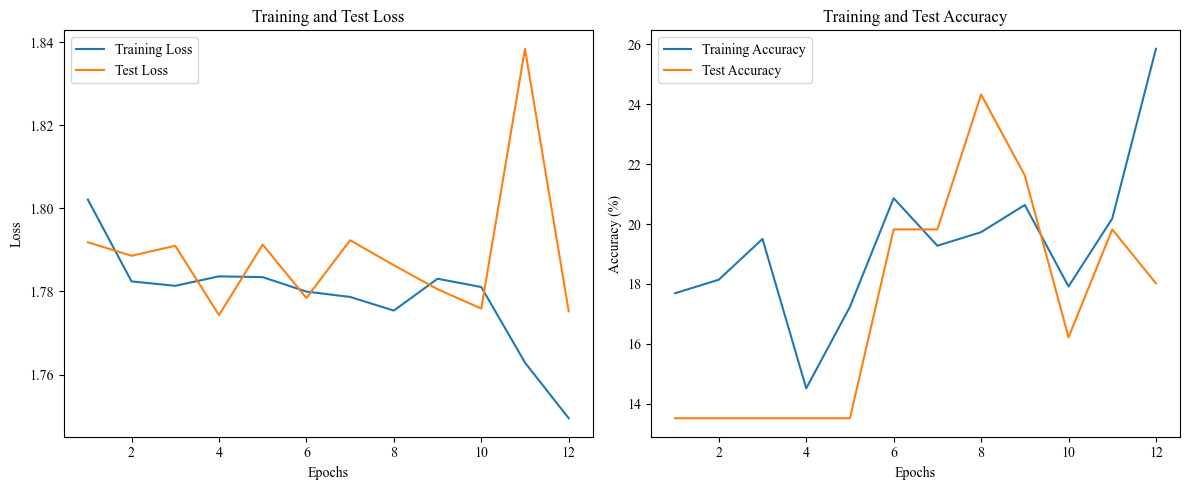

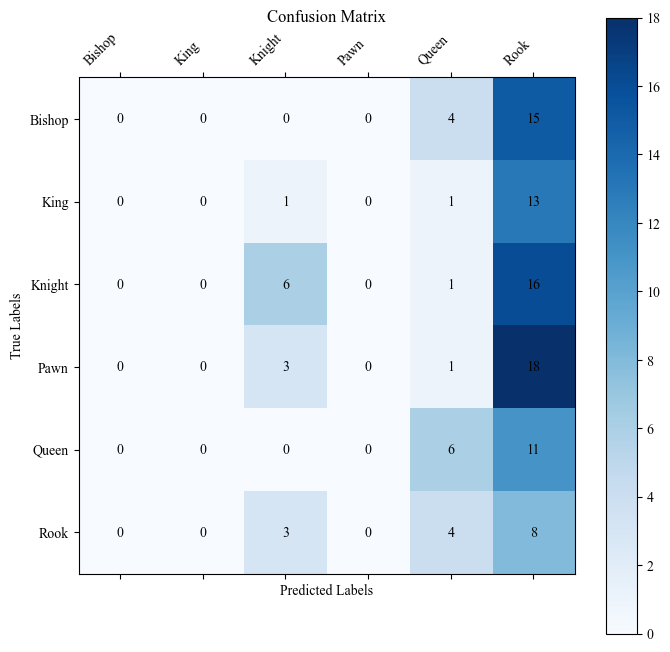

In [35]:
# Configuración inicial
model = ConvNet3(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Podemos observar que este clasificador no puede clasificar bien los datos. Por tanto, ninguno de los probados obtiene un resultado aceptable, por lo que vamos a preprocesar primero las imágenes con OpenCV para detectar bordes y que el clasificador pueda mejorar sus resultados.

## **Preprocesamiento de Imágenes utilizando OpenCV**
#### **Métodos Utilizados**
##### **1. Detección de Bordes y Refinamiento de Imágenes**
La siguiente función `detect_edges_and_refine()` que detecta bordes en imágenes, refina los contornos, recorta la imagen y opcionalmente guarda la imagen procesada. Primero, valida que la imagen exista y pueda cargarse correctamente. Luego, realiza un preprocesamiento que incluye redimensionar la imagen a 256x256 píxeles, convertirla a escala de grises y suavizarla con un desenfoque gaussiano. A continuación, utiliza el detector de bordes Canny para identificar transiciones intensas, engrosando estos bordes mediante una dilatación. Posteriormente, detecta los contornos de las áreas resaltadas y los dibuja sobre una imagen en blanco. Finalmente, extrae una fracción específica de la imagen procesada (por defecto, la mitad superior) y, si se especifica, guarda esta imagen en un directorio de salida.

In [31]:
def detect_edges_and_refine(image_path, save_processed_image=False, output_dir=None, fraction=1/2, grosor=1): 
    
    # Normalizar las barras en la ruta
    normalized_path = image_path.replace("\\", "/")

    # Verificar si la imagen existe
    if not os.path.exists(normalized_path):
        print(f"Error: La imagen {normalized_path} no existe.")
        return None

    # Intentar cargar la imagen
    image = cv2.imread(normalized_path)
    if image is None:
        print(f"Error: No se pudo cargar la imagen en {normalized_path}.\nPosiblemente esté dañada o el formato no es compatible.")
        return None

    # Redimensionar y preprocesar la imagen
    image_resized = cv2.resize(image, (256, 256))
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detección de bordes
    edges = cv2.Canny(blurred, threshold1=50, threshold2=200)

    # Engrosar bordes
    kernel = np.ones((3, 3), np.uint8)
    thick_edges = cv2.dilate(edges, kernel, iterations=2)

    # Encontrar contornos
    contours, _ = cv2.findContours(thick_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(image_resized)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), grosor)

    # Extraer una fracción de la imagen
    height, _ = contour_image.shape[:2]
    if not (0 < fraction <= 1):
        raise ValueError("fraction debe estar en el rango (0, 1].")
    upper_fraction = contour_image[:int(height * fraction), :]

    # Guardar la imagen procesada si se especifica
    if save_processed_image and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        processed_image_path = os.path.join(output_dir, os.path.basename(image_path))
        cv2.imwrite(processed_image_path, upper_fraction)
    
    return upper_fraction

##### **2. Procesamiento del Conjunto de Datos**
La función `process_dataset` procesa automáticamente un conjunto completo de datos de imágenes, aplicando la detección y refinamiento de bordes a cada archivo. Primero, crea un directorio de salida junto con subdirectorios que replican la estructura de clases del directorio de entrada. Luego, itera sobre cada clase (subcarpeta) y procesa todas las imágenes dentro de ella utilizando la función `detect_edges_and_refine`. Durante este procesamiento, maneja posibles errores individualmente para que no se interrumpa el análisis de todo el conjunto de datos. Las imágenes procesadas se guardan en el directorio de salida, manteniendo la organización de las carpetas del conjunto original.

In [32]:

def process_dataset(input_dir, output_dir, fraction = 1/2, grosor=1):
    
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            output_class_path = os.path.join(output_dir, class_name)
            os.makedirs(output_class_path, exist_ok=True)

            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    processed_image = detect_edges_and_refine(
                        image_path, save_processed_image=True, output_dir=output_class_path, fraction=fraction, grosor=grosor
                    )
                except Exception as e:
                    print(f"Error procesando {image_name}: {e}")

#### **Procesamiento del Conjunto de Datos con Diferentes Configuraciones**
A continuación, preprocesamos los datos con diferentes configuraciones de recorte y engrosamiento de bordes para encontrar la mejor configuración.

In [33]:
input_dataset_dir = 'data/chess/raw'

output_processed_dir = 'data/chess/processed/Chess-processed1'
process_dataset(input_dataset_dir, output_processed_dir, 1/2, 1)

output_processed_dir = 'data/chess/processed/Chess-processed2'
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 2)

output_processed_dir = 'data/chess/processed/Chess-processed3'
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 6)

output_processed_dir = 'data/chess/processed/Chess-processed4'
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 10)

Error: No se pudo cargar la imagen en data/chess/raw/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/chess/raw/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/chess/raw/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/chess/raw/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.


### **Clasificadores para los datos procesados**
A continuación, vamos a definir nuevos clasificadores con el objetivo de clasificar los datos ya procesados.
#### **ConvNet4**
La red **ConvNet4** está diseñada con cuatro capas convolutivas seguidas de operaciones de pooling y dos capas totalmente conectadas al final con una de dropout en medio. Y como función de activación utiliza la ReLu. Esta arquitectura permite extraer características espaciales de las imágenes y realizar la clasificación en función de esas características.

In [37]:
class ConvNet4(nn.Module):
    def __init__(self, classes):
        super(ConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        # print(x.shape)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x) 
        return x

#### **ConvNet5**
La red **ConvNet5** es una arquitectura más profunda y compleja, diseñada con seis capas convolutivas y operaciones de pooling, seguida de dos capas totalmente conectadas. Esta red puede capturar características más detalladas y complejas de las imágenes, lo que la hace ideal para tareas de clasificación en conjuntos de datos con alta variabilidad. También incorpora dropout para prevenir el sobreajuste. Y como función de activación tiene una ReLu.

In [38]:

class ConvNet5(nn.Module):
    def __init__(self, classes):
        super(ConvNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        # print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### **Transformaciones Avanzadas**
Dado que son los datos los que no permiten obtener buenos resultados en la clasificación, vamos a implementar la técnica de aumento de datos (data augmentation) más compleja para los datos de entrenamiento. En este caso, haremos giros y rotaciones, recortes y cambios en el color.

In [40]:
# Conjunto de Entrenamiento
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.4, hue=0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Conjunto de Prueba
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### **Experimentos con datos procesados**
#### **Chess-processed1**
A este conjunto de datos se le ha recortado la mitad superior de los datos y se le ha aplicado un grosor de 1 unidad.

In [41]:
# Ruta de las imágenes
data_path = 'data/chess/processed/Chess-processed1'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Primero, vamos a utilizar el clasificador con 4 capas convolutivas a ver qué resultados obtenemos:

Epoch 1, Training Loss: 1.7931698092392512, Training Accuracy: 15.646258503401361%
Epoch 1, Test Loss: 1.7862860815865653, Test Accuracy: 16.216216216216218%
Epoch 2, Training Loss: 1.7870090774127416, Training Accuracy: 19.954648526077097%
Epoch 2, Test Loss: 1.7859813826424735, Test Accuracy: 16.216216216216218%
Epoch 3, Training Loss: 1.7898091546126775, Training Accuracy: 19.954648526077097%
Epoch 3, Test Loss: 1.7828035865511214, Test Accuracy: 16.216216216216218%
Epoch 4, Training Loss: 1.7867460123130254, Training Accuracy: 19.954648526077097%
Epoch 4, Test Loss: 1.7848032883235387, Test Accuracy: 16.216216216216218%
Epoch 5, Training Loss: 1.786359476191657, Training Accuracy: 19.501133786848072%
Epoch 5, Test Loss: 1.7810919795717512, Test Accuracy: 16.216216216216218%
Epoch 6, Training Loss: 1.7859593629837036, Training Accuracy: 19.727891156462587%
Epoch 6, Test Loss: 1.7806829384395055, Test Accuracy: 16.216216216216218%
Parada temprana activada. No hay mejora en la pérdida

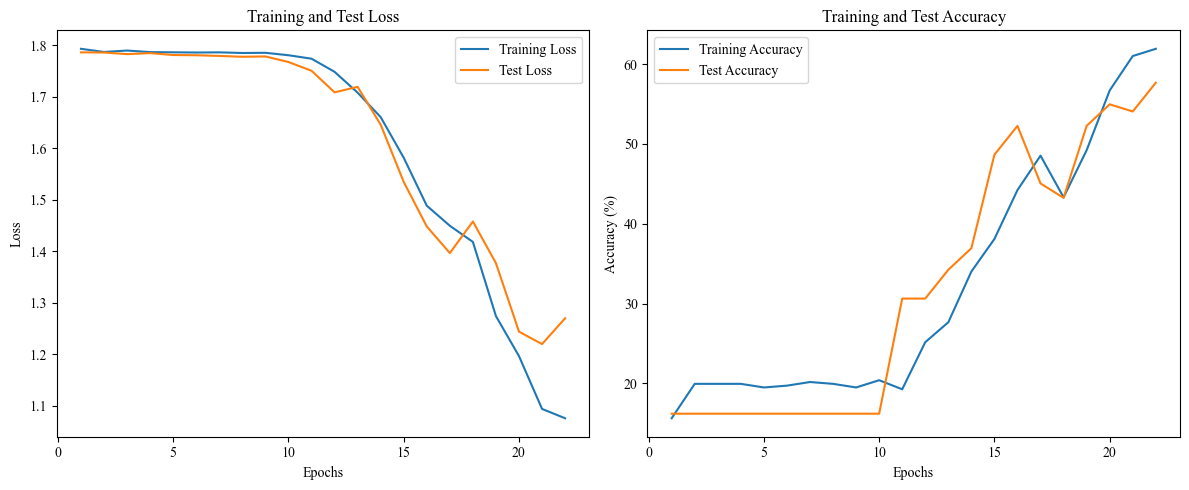

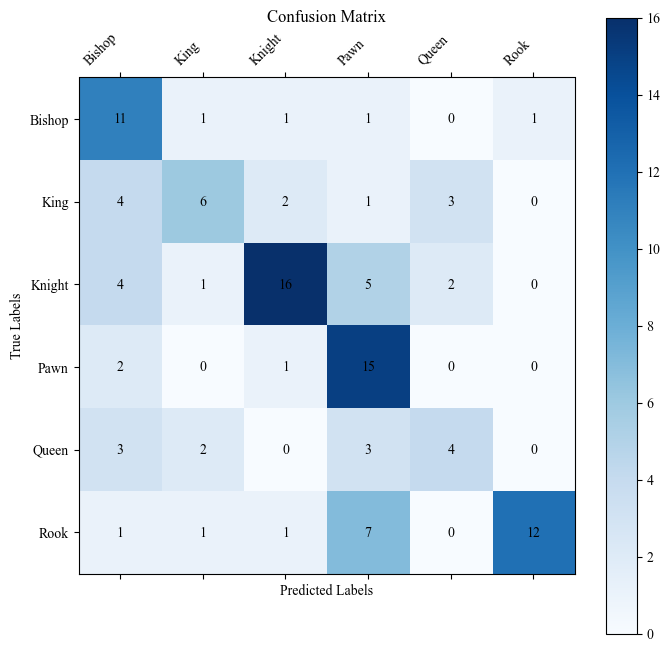

In [46]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=20)

Podemos observar que ha mejorado bastante el resultado con el preprocesado de los datos, aunque aún hay piezas que confunde como la dama, el alfil y el rey.

Veamos qué ocurre con otras configuraciones.

### **Chess-processed2**
Estos datos procesados representan dos tercios superiores de los datos originales, con bordes de un grosor de 2 unidades.

In [49]:
# Ruta de las imágenes
data_path = 'data/chess/processed/Chess-processed2'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Epoch 1, Training Loss: 1.7918934055737086, Training Accuracy: 18.820861678004537%
Epoch 1, Test Loss: 1.788080436842782, Test Accuracy: 18.91891891891892%
Epoch 2, Training Loss: 1.784824320248195, Training Accuracy: 18.820861678004537%
Epoch 2, Test Loss: 1.7867793185370309, Test Accuracy: 18.91891891891892%
Epoch 3, Training Loss: 1.76958886214665, Training Accuracy: 19.27437641723356%
Epoch 3, Test Loss: 1.7594014406204224, Test Accuracy: 26.126126126126128%
Epoch 4, Training Loss: 1.6705861602510725, Training Accuracy: 29.024943310657598%
Epoch 4, Test Loss: 1.7477087123053414, Test Accuracy: 25.225225225225227%
Epoch 5, Training Loss: 1.5921626601900374, Training Accuracy: 32.19954648526077%
Epoch 5, Test Loss: 1.7383043084825789, Test Accuracy: 24.324324324324323%
Epoch 6, Training Loss: 1.4359828616891588, Training Accuracy: 40.136054421768705%
Epoch 6, Test Loss: 1.6593202693121774, Test Accuracy: 34.234234234234236%
Epoch 7, Training Loss: 1.1957645075661796, Training Accurac

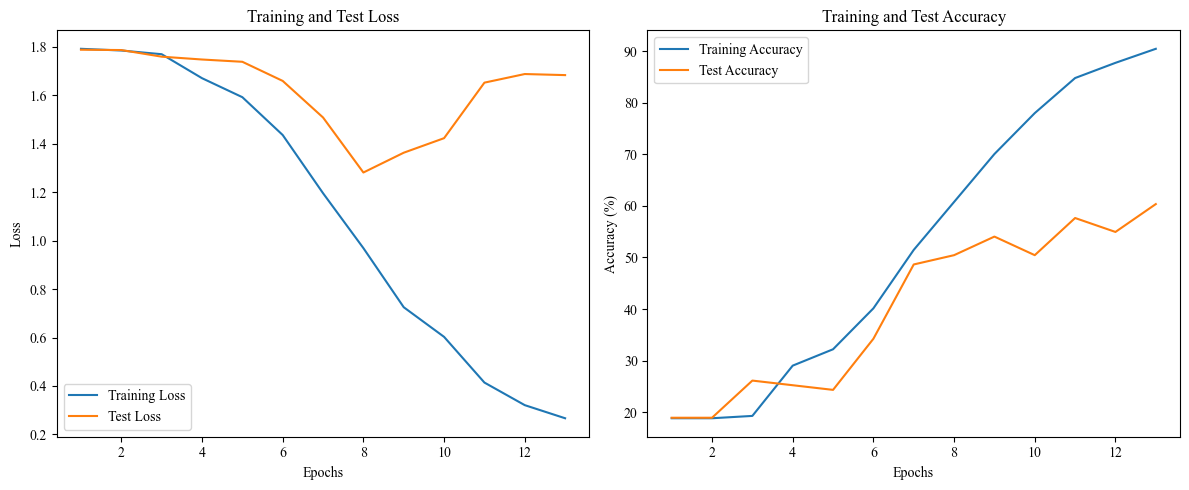

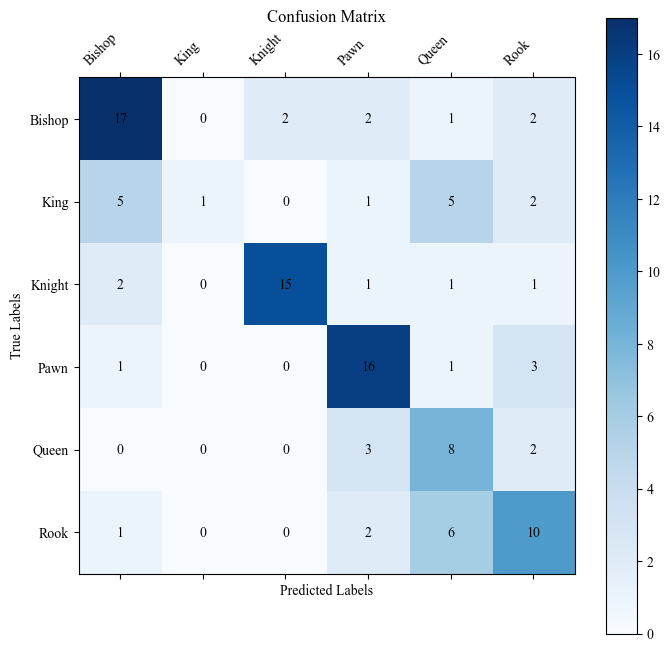

In [51]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Atendiendo a los resultados, podemos observar que se obtiene un resultado similar al anterior experimento con otro conjunto de datos. Sin embargo, vemos que ahora las pizas que confunde más son el rey con el alfil y la dama y la dama con la torre. 

Probemos otro procesado de datos.

### **Chess-processed3**
Estos datos aumentan de 2 a 6 el grosor, comparados con los datos `Chess-processed2`. Observemos su comportamiento.

In [53]:
# Ruta de las imágenes
data_path = 'data/chess/processed/Chess-processed3'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Epoch 1, Training Loss: 1.8127978146076202, Training Accuracy: 17.006802721088434%
Epoch 1, Test Loss: 1.7907672779900687, Test Accuracy: 18.91891891891892%
Epoch 2, Training Loss: 1.7896351303373064, Training Accuracy: 18.140589569160998%
Epoch 2, Test Loss: 1.782317774636405, Test Accuracy: 18.91891891891892%
Epoch 3, Training Loss: 1.7647290783269065, Training Accuracy: 20.861678004535147%
Epoch 3, Test Loss: 1.7092493261609758, Test Accuracy: 27.92792792792793%
Epoch 4, Training Loss: 1.6981816802706038, Training Accuracy: 24.489795918367346%
Epoch 4, Test Loss: 1.6468034301485335, Test Accuracy: 25.225225225225227%
Epoch 5, Training Loss: 1.6194859402520316, Training Accuracy: 32.87981859410431%
Epoch 5, Test Loss: 1.5177116223743983, Test Accuracy: 35.13513513513514%
Epoch 6, Training Loss: 1.4670609746660506, Training Accuracy: 37.641723356009074%
Epoch 6, Test Loss: 1.3639439344406128, Test Accuracy: 35.13513513513514%
Epoch 7, Training Loss: 1.208134406379291, Training Accurac

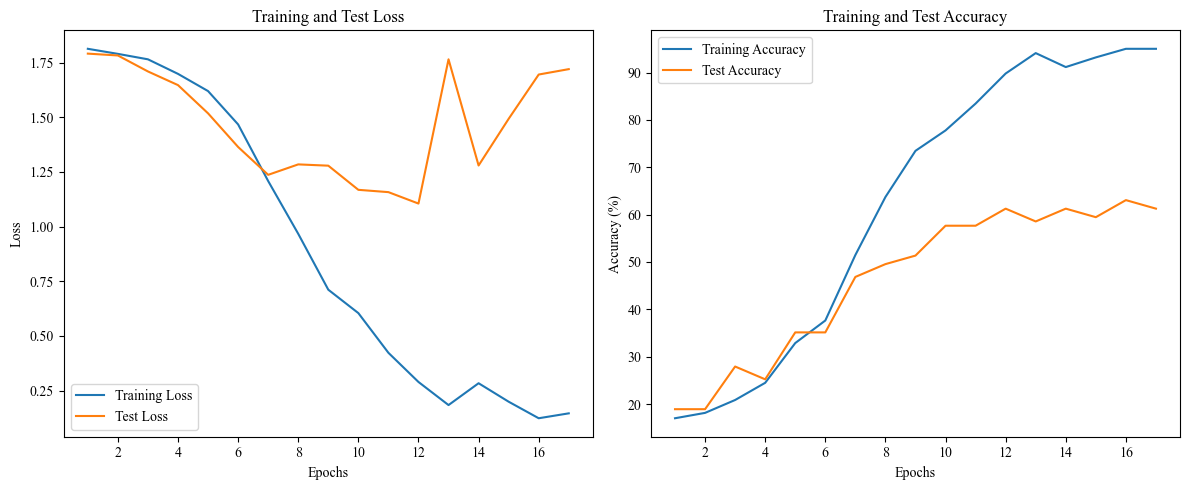

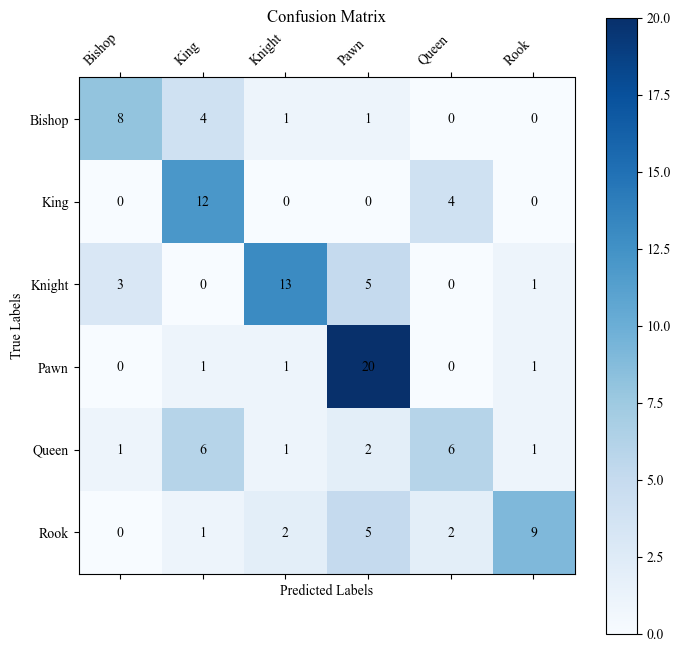

In [55]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=5)

En este caso, el modelo ha sobreajustado bastante durante el final del entrenamiento. Comprobemos con una red con 6 capas convolutivas a ver qué ocurre.

Epoch 1, Training Loss: 1.7961413604872567, Training Accuracy: 17.46031746031746%
Epoch 1, Test Loss: 1.782652531351362, Test Accuracy: 19.81981981981982%
Epoch 2, Training Loss: 1.7847834186894553, Training Accuracy: 17.687074829931973%
Epoch 2, Test Loss: 1.7655964749200004, Test Accuracy: 21.62162162162162%
Epoch 3, Training Loss: 1.7207814838205064, Training Accuracy: 25.62358276643991%
Epoch 3, Test Loss: 1.7262103046689714, Test Accuracy: 16.216216216216218%
Epoch 4, Training Loss: 1.6949962377548218, Training Accuracy: 23.12925170068027%
Epoch 4, Test Loss: 1.7301160608019148, Test Accuracy: 21.62162162162162%
Epoch 5, Training Loss: 1.623820002589907, Training Accuracy: 26.303854875283445%
Epoch 5, Test Loss: 1.63988425050463, Test Accuracy: 28.82882882882883%
Epoch 6, Training Loss: 1.5297133496829443, Training Accuracy: 26.984126984126984%
Epoch 6, Test Loss: 1.5524833372661047, Test Accuracy: 33.333333333333336%
Epoch 7, Training Loss: 1.4461618278707777, Training Accuracy: 

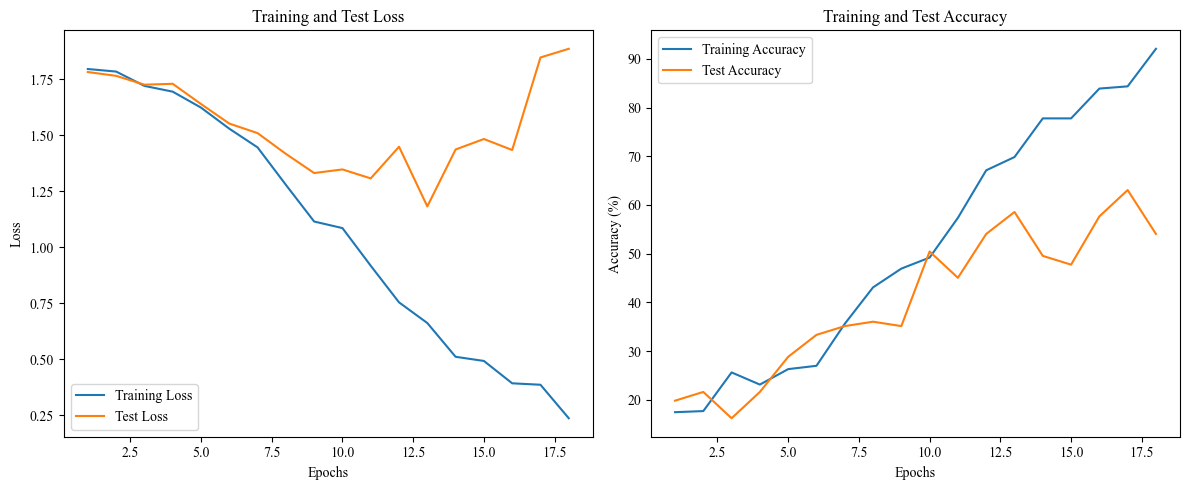

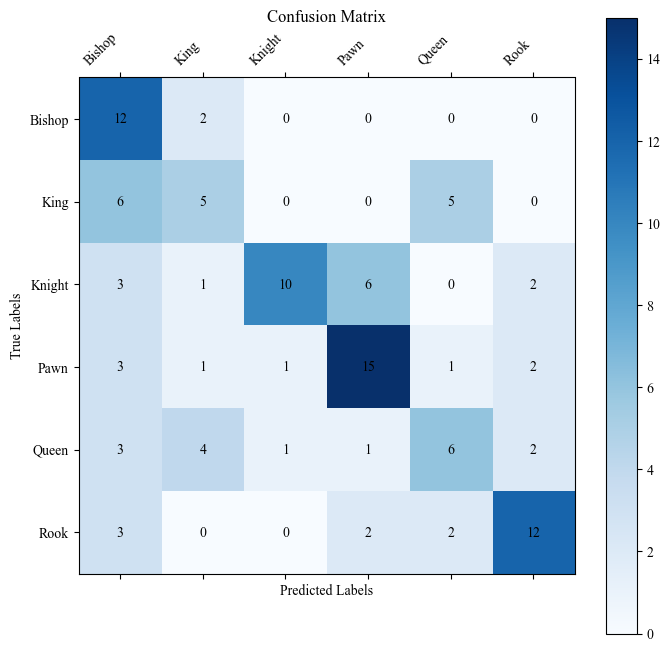

In [56]:
model = ConvNet5(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Con esta otra red también sobreajusta para este conjunto de datos. Probemos con otro a ver si mejora los resultados obtenidos anteriormente.

### **Chess-processed4**
Este conjunto de datos recorta dos tercios superiores de las imágenes originales y aplica un grosor de 10 unidades a los bordes.

In [68]:
# Ruta de las imágenes
data_path = 'data/chess/processed/Chess-processed4'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Epoch 1, Training Loss: 1.7945195095879691, Training Accuracy: 16.3265306122449%
Epoch 1, Test Loss: 1.797312821660723, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.7850757709571294, Training Accuracy: 21.541950113378686%
Epoch 2, Test Loss: 1.7523744106292725, Test Accuracy: 24.324324324324323%
Epoch 3, Training Loss: 1.701832264661789, Training Accuracy: 24.489795918367346%
Epoch 3, Test Loss: 1.7321834393909998, Test Accuracy: 28.82882882882883%
Epoch 4, Training Loss: 1.6103718961988176, Training Accuracy: 34.92063492063492%
Epoch 4, Test Loss: 1.683557186807905, Test Accuracy: 36.03603603603604%
Epoch 5, Training Loss: 1.4543991855212621, Training Accuracy: 39.682539682539684%
Epoch 5, Test Loss: 1.499535185950143, Test Accuracy: 40.54054054054054%
Epoch 6, Training Loss: 1.2493540325335093, Training Accuracy: 48.75283446712018%
Epoch 6, Test Loss: 1.245198062488011, Test Accuracy: 58.55855855855856%
Epoch 7, Training Loss: 0.986713924578258, Training Accuracy: 60.

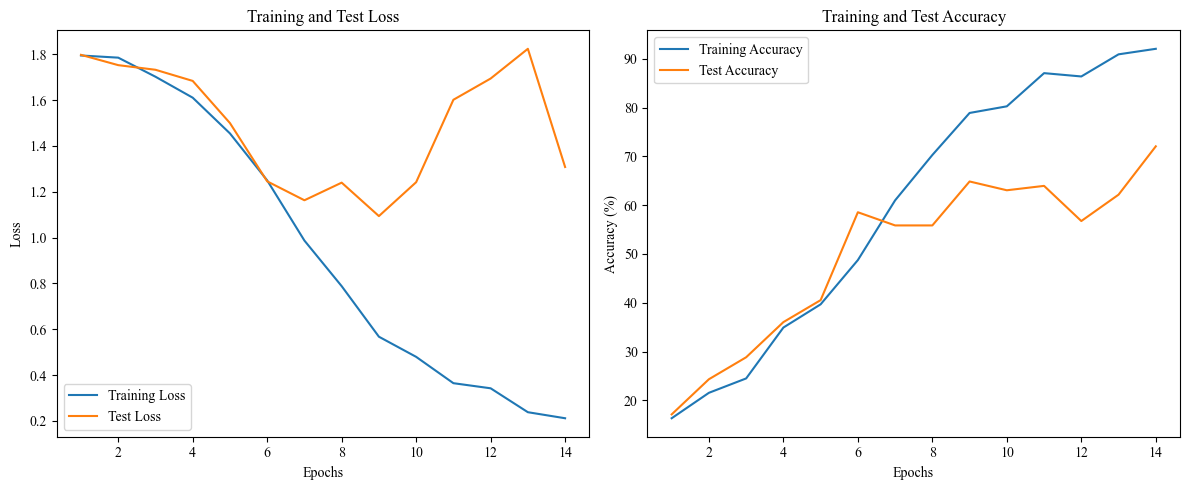

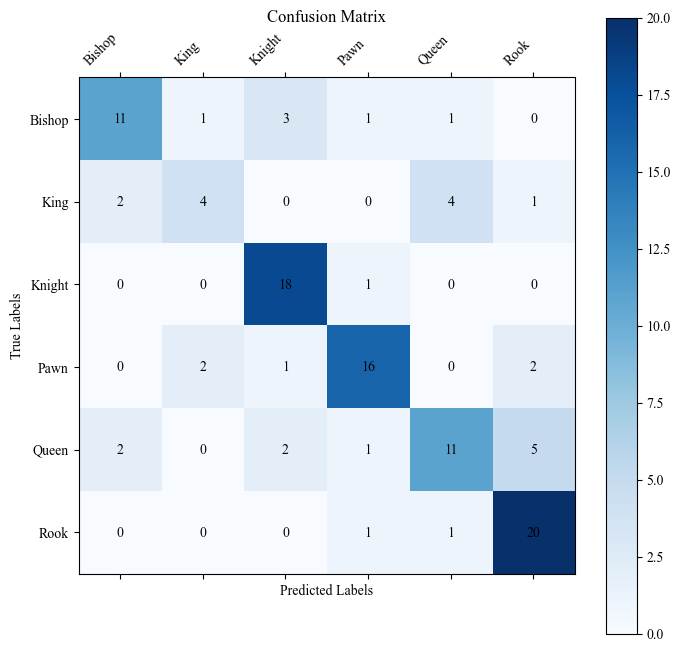

In [69]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Este conjunto de datos con la red con 4 capas convolutivas también sobreajusta al final del entrenamiento aunque obtiene un resultado similar a los anteriores sobre la época 10. 

Comprobemos el comportamiento con una red con 6 capas convolutivas.

Epoch 1, Training Loss: 1.7882417568138667, Training Accuracy: 18.140589569160998%
Epoch 1, Test Loss: 1.7921078034809657, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.7737719203744615, Training Accuracy: 20.18140589569161%
Epoch 2, Test Loss: 1.7770344870431083, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.7431029847690038, Training Accuracy: 24.03628117913832%
Epoch 3, Test Loss: 1.7546507971627372, Test Accuracy: 23.423423423423422%
Epoch 4, Training Loss: 1.6641814921583449, Training Accuracy: 29.024943310657598%
Epoch 4, Test Loss: 1.7967448745455061, Test Accuracy: 29.72972972972973%
Epoch 5, Training Loss: 1.621343127318791, Training Accuracy: 30.839002267573697%
Epoch 5, Test Loss: 1.6860476561955042, Test Accuracy: 28.82882882882883%
Epoch 6, Training Loss: 1.5608272041593279, Training Accuracy: 33.333333333333336%
Epoch 6, Test Loss: 1.60504754952022, Test Accuracy: 29.72972972972973%
Epoch 7, Training Loss: 1.4641298651695251, Training Accuracy

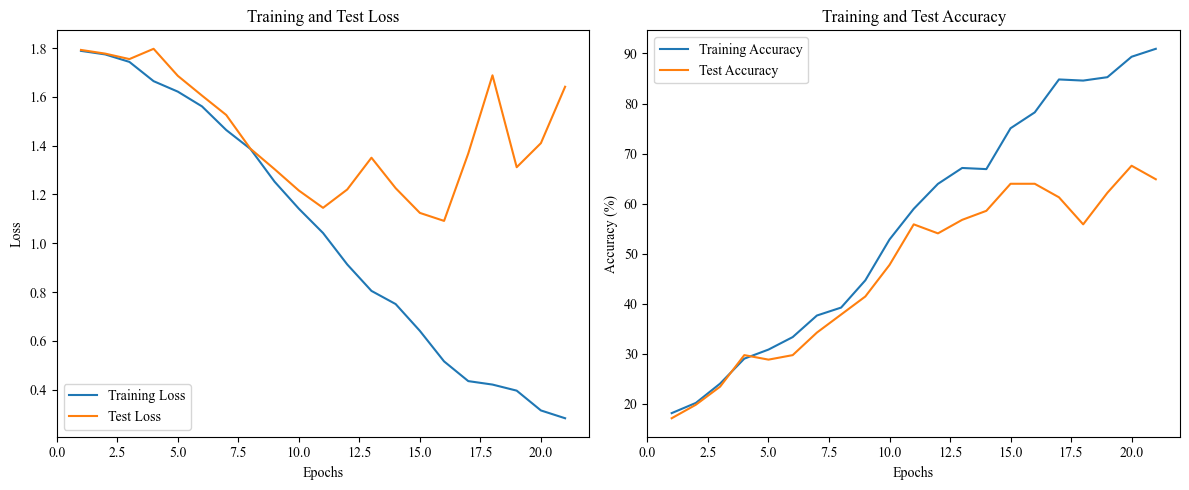

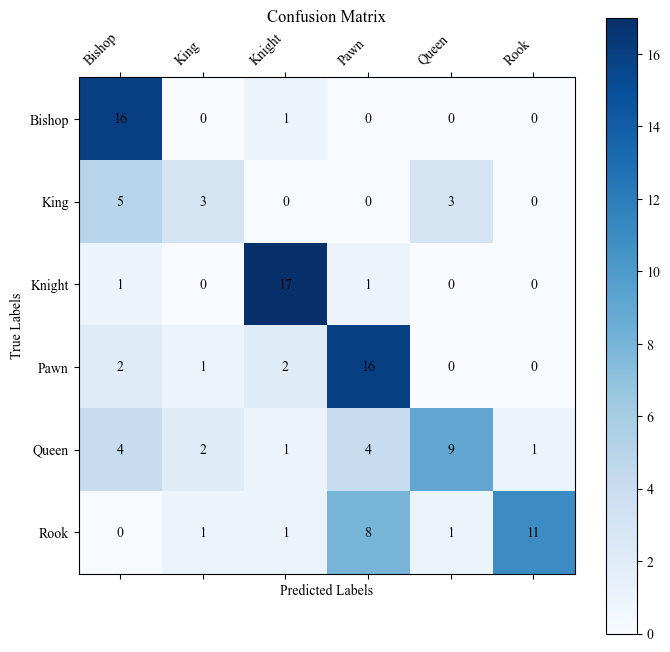

In [70]:
model = ConvNet5(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Para este caso, también sobreajusta en las últimas épocas y obtiene un resultado similar al anterior en la época 15.

## **ResNet-18**
ResNet-18 es un tipo de red residual que permite el desarrollo de redes más profundas sin que afecte el desvanecimiento del gradiente. Esto sucede gracias a los bloques o módulos residuales. 

El desvanecimiento del gradiente es un problema al que se enfrenta toda red lo suficientemente profunda. Los valores de los gradientes se van despreciando debido a la gran profundidad de la red y el aprendizaje es casi insignificante.

Por tanto, este tipo de red utiliza unos módulos residuales que conectan las entradas con las salidas y evitan dicho desvanecimiento.

#### **1. Recorte de la Parte Superior en Imágenes**
Realizamos un recorte del 60% superior de las imágenes, ya que la parte inferior de las piezas son iguales.

In [71]:
def crop_top(img):
    width, height = img.size
    return img.crop((0, 0, width, int(height * 0.6)))

#### **2. Transformaciones y Carga de Datos**
Definimos la transformación de las imágenes con un recorte superior, redimensión de las mismas a un tamaño de e 224x224 píxeles (necesario para ResNet18), convertimos a tensor y normalizamos la imagen a un rango entre -1 y 1.

Luego, cargamos las imágenes, les aplicamos las transformaciones y las dividimos aleatoriamente en entrenamiento (80%) y validación (20%).

In [72]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Lambda(crop_top),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/chess/raw'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

#### **3. Entrenamiento del Modelo**
A continuación, entrenamos el modelo. Para ello, cargamos el modelo preentrenado ResNet18, definimos la función de pérdida y el optimizador, entrenamos 10 épocas y graficamos los resultados.


In [73]:
# Cargar un modelo preentrenado (ResNet18)
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_data.classes))  # Ajustar la salida al número de clases

# Definir optimizador y función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Entrenamiento
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {100 * correct / total}%")

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())  
            all_preds.extend(predicted.cpu().numpy())

            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {100 * correct / total}%")

c:\Users\chess\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chess\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Training Loss: 0.9983762853911945, Training Accuracy: 66.43990929705215%
Epoch 1, Test Loss: 0.9076656486306872, Test Accuracy: 71.17117117117117%
Epoch 2, Training Loss: 0.4059540943375656, Training Accuracy: 87.3015873015873%
Epoch 2, Test Loss: 0.506712658064706, Test Accuracy: 85.58558558558559%
Epoch 3, Training Loss: 0.23851494451186486, Training Accuracy: 92.06349206349206%
Epoch 3, Test Loss: 0.32780636314834866, Test Accuracy: 88.28828828828829%
Epoch 4, Training Loss: 0.14632332028954156, Training Accuracy: 95.01133786848072%
Epoch 4, Test Loss: 0.36524011035050663, Test Accuracy: 89.1891891891892%
Epoch 5, Training Loss: 0.08061791433387303, Training Accuracy: 98.1859410430839%
Epoch 5, Test Loss: 0.3403242453932762, Test Accuracy: 90.09009009009009%
Epoch 6, Training Loss: 0.05300003040714988, Training Accuracy: 98.41269841269842%
Epoch 6, Test Loss: 0.25714446923562456, Test Accuracy: 93.69369369369369%
Epoch 7, Training Loss: 0.1726862144756264, Training Accuracy

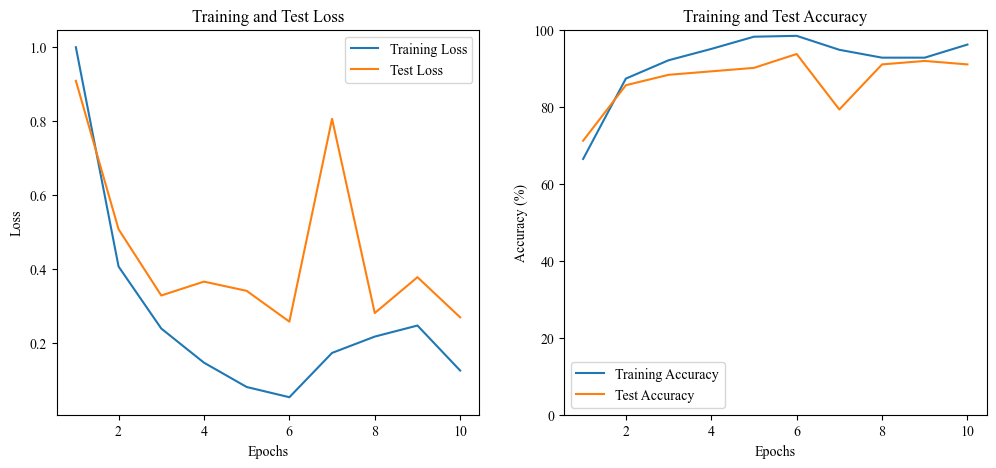

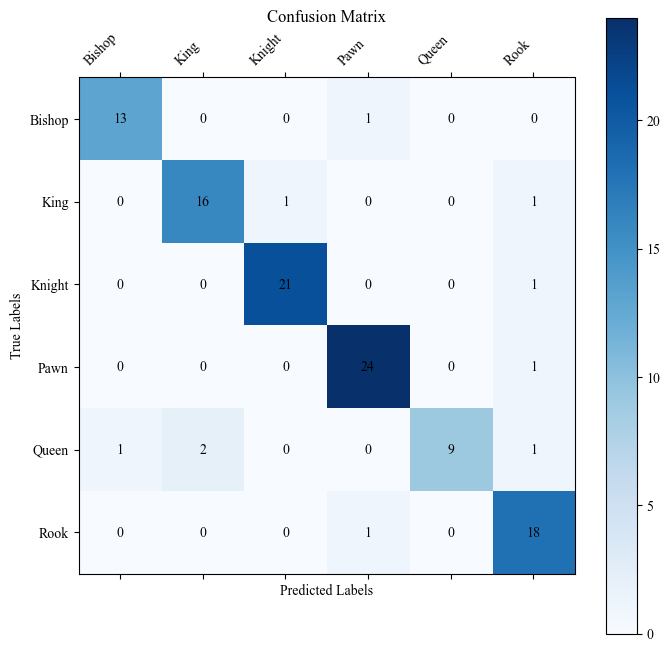

In [75]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Gráfico de pérdidas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100) 
plt.title("Training and Test Accuracy")
plt.legend()

# Matriz de Confusión
num_classes = len(full_data.classes)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(all_labels, all_preds):
    confusion_matrix[true_label, pred_label] += 1

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(confusion_matrix, cmap='Blues')
plt.colorbar(cax)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(full_data.classes, rotation=45, ha="right")
ax.set_yticklabels(full_data.classes)

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Vemos que los resultados obtenidos con ResNet-18 mejoran con creces los obtenidos con los clasificadores probados anteriormente. Solo existen algunos errores aislados pero alcanza un 90% de precisión, que es muy buen porcentaje.

## **Conclusión**


En resumen, los experimentos realizados evidencian la evolución en el desempeño de los modelos al aplicar diferentes estrategias y arquitecturas. Las primeras pruebas con modelos básicos revelaron limitaciones significativas, como el sobreajuste temprano y la incapacidad de generalizar correctamente. Aunque la implementación de técnicas como la parada temprana ayudó a mitigar este problema, los resultados seguían siendo insuficientes para muchas clases del conjunto de datos.

El uso de configuraciones más complejas, como redes con mayor número de capas y dropout, mejoró ligeramente la precisión en algunos casos, pero también aumentó las confusiones entre clases similares. Por otra parte, los experimentos con preprocesamiento de imágenes utilizando OpenCV representaron un avance importante, logrando una mejora notable en la precisión general del modelo. Ha mejorado los primeros resultados obtenidos con las imágenes originales, aumentando alredor del 30% de precisión. Asimismo, los resultados obtenidos con el conjunto de datos `Chess-processed1` y la red `ConvNet4` son los más estables alcanzando un 57%. No obstante, los obtenidos con el conjunto `Chess-processed4` y la red `ConvNet4` alcanzan una cifra similar antes del sobreajuste. 

Finalmente, el uso de arquitecturas avanzadas como ResNet-18 marcó un punto de inflexión al alcanzar una precisión superior y una mayor capacidad de generalización, destacándose como una opción robusta. En conjunto, los resultados confirman que la elección de la arquitectura y el preprocesamiento son determinantes para abordar de manera eficiente problemas de clasificación complejos.